<a href="https://colab.research.google.com/github/Katanov/DA_projects/blob/main/Yandex_Zen_Testovoe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Тестовое задание Дзена

- Предложите метрики по которым Дзену стоит оценивать эффективность привлечения пользователей из разных каналов мобильной дистрибуции.
Расскажите про эти метрики, про факторы, которые они позволяют правильно учесть, про их минусы.

- Сделайте сравнение каналов дистрибуции по вашим метрикам, дайте рекомендации, как можно увеличить эффективность привлечения пользователей. Рекомендации с точки зрения бизнеса (что делать с конкретными кампаниями), так и со стороны аналитики (какие еще метрики посчитать, какие данные собирать, по каким критериям принимать финальное решения о кампании).

### Загружаем и обрабатываем данные

In [149]:
import pandas as pd
import plotly.express as px
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from plotly import graph_objects as go
pd.options.display.max_colwidth = 1000
import warnings
warnings.filterwarnings("ignore")

In [150]:
active = pd.read_csv('drive/My Drive/ТЗ_ПА/activations.tsv', sep = '\t')
metrika = pd.read_csv('drive/My Drive/ТЗ_ПА/app_metrika_events.tsv', sep = '\t')
zen = pd.read_csv('drive/My Drive/ТЗ_ПА/zen_log_events.tsv', sep = '\t')

In [151]:
print(active.info(),metrika.info(),zen.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159344 entries, 0 to 159343
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   activation_date    159344 non-null  object
 1   activation_type    159344 non-null  object
 2   app_version        159344 non-null  object
 3   device_id          159344 non-null  uint64
 4   distr_channel      159344 non-null  object
 5   manufacturer_code  159344 non-null  uint64
 6   model_code         159344 non-null  uint64
dtypes: object(4), uint64(3)
memory usage: 8.5+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1344311 entries, 0 to 1344310
Data columns (total 5 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   app_version   1344311 non-null  object
 1   device_id     1344311 non-null  uint64
 2   event         1344311 non-null  object
 3   eventdate     1344311 non-null  object
 4   events_count  1344311 non-

In [152]:
metrika['eventdate'] = pd.to_datetime(metrika.eventdate)
active['activation_date'] = pd.to_datetime(active.activation_date)
zen['eventdate'] = pd.to_datetime(zen.eventdate)

In [153]:
active.head()

,activation_date,activation_type,app_version,device_id,distr_channel,manufacturer_code,model_code
0,2019-08-24,activation,3.6.0,696332390497458505,campaign_1,15376561573962667727,7913129442748736194
1,2019-08-25,activation,3.6.0,3893213900620425204,campaign_1,15376561573962667727,17990533160808913744
2,2019-09-04,activation,4.1.0,4926404455081332295,campaign_3,9176196626556171601,2071872023119905196
3,2019-09-02,activation,3.6.0,5643480570740241301,campaign_1,15376561573962667727,7913129442748736194
4,2019-09-07,activation,3.6.0,6298637473167669905,campaign_1,15376561573962667727,7913129442748736194


In [154]:
metrika.head()

,app_version,device_id,event,eventdate,events_count
0,3.6.0,696332390497458505,show,2019-08-24,10
1,3.6.0,696332390497458505,click,2019-09-13,1
2,3.6.0,696332390497458505,show,2019-08-26,1
3,3.6.0,696332390497458505,show,2019-08-25,7
4,3.6.0,696332390497458505,notification open,2019-09-09,1


In [155]:
zen.head()

,app,block,click,device_id,dislike,eventdate,like,notification_click,preview_click,preview_show,short,show,subscription
0,Yandex Browser Mobile,0,0,12186593417815901104,0,2019-08-24,0,0,0,0,3,0,0
1,Yandex Browser Mobile,0,0,4085397072091507960,0,2019-08-23,0,0,0,0,1,0,0
2,Yandex Browser Mobile,0,1,3338224551360680147,0,2019-07-20,0,0,0,0,0,0,0
3,Yandex Browser Mobile,0,0,4521556704468469702,0,2019-09-14,0,0,0,0,1,0,0
4,Yandex Browser Mobile,0,4,17683256281706953618,0,2019-09-02,0,0,0,2,16,6,0


In [156]:
zen.isnull().mean()

app                   0.0
block                 0.0
click                 0.0
device_id             0.0
dislike               0.0
eventdate             0.0
like                  0.0
notification_click    0.0
preview_click         0.0
preview_show          0.0
short                 0.0
show                  0.0
subscription          0.0
dtype: float64

In [157]:
metrika.isnull().mean()

app_version     0.0
device_id       0.0
event           0.0
eventdate       0.0
events_count    0.0
dtype: float64

In [158]:
active.isnull().mean()

activation_date      0.0
activation_type      0.0
app_version          0.0
device_id            0.0
distr_channel        0.0
manufacturer_code    0.0
model_code           0.0
dtype: float64

In [159]:
len(metrika)

1344311

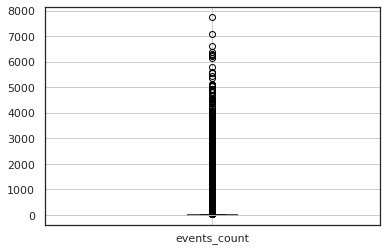

In [160]:
metrika.boxplot(column=['events_count'])

In [161]:
Q1 = metrika['events_count'].quantile(0.25)
Q3 = metrika['events_count'].quantile(0.75)
IQR = Q3 - Q1

In [162]:
metrika = metrika[metrika.events_count < (Q3 + 1.5 * IQR)]

In [163]:
#metrika = metrika[metrika.events_count < metrika.events_count.quantile(0.95)]

In [164]:
len(metrika)

1146061

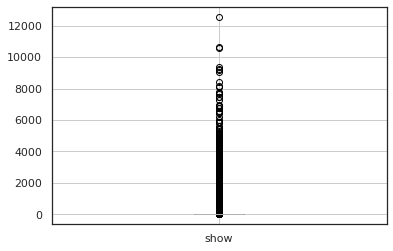

In [165]:
zen.boxplot(column="show")

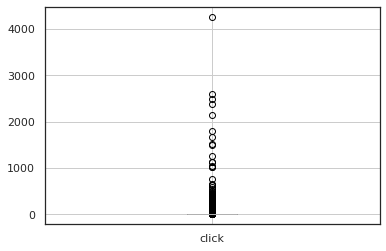

In [166]:
zen.boxplot(column="click")

In [167]:
len(zen)

1619486

In [168]:
zen = zen[zen.click < zen.click.quantile(0.95)]

In [169]:
zen = zen[zen.show < zen.show.quantile(0.95)]

In [170]:
len(zen)

1459638

### Формируем гипотезы и проверяем их

Исходя из данных выше, я выбрал две ключевых метрики и одну связанную с ними характеристику, которые будут здесь наиболее важны для анализа каналов привлечения трафика:

- CTR: безусловно конверсия из показов в клики для сервиса крайне важна, ибо хорошие показатели CTR = классные кейсы рекламодателей = еще больше новых рекламодателей = еще больше рекламного трафика, проходящего через площадку.
- Retention rate: одим CTR'ом сыт не будешь, поэтому проверить живучесть пользователей тоже стоит. Если канал приносит трафик, который активно взаимодействует с площадкой лишь в течение одной недели, а потом уходит в отток - то здесь явно что-то не так :)
- Конверсия в онбординг: вероятно, прохождение онбординга существенно упрощает алгоритмам сервиса жизнь по подбору релеватного контента для пользователя. Более релеватный контент = лучше кликабельность и дольше жизнь пользователя.

Также хочу проверить влияние места первого взаимодействия с Дзеном. Условно гипотеза будет звучать так: Если человек первым касанием познакомился с Дзеном через приложение, то вероятность, что он пройдет обординг - выше.


### Влияет ли прохождение онбординга и место первого взаимодействия с Дзеном на ключевые показатели

In [171]:
def rule(x):
    if x == "onboarding":
         return 1
    else:
         return 0

In [172]:
metrika['onboarding'] = metrika.apply(lambda x: rule(x['event']), axis =  1)

In [173]:
metrika_with_onboard = metrika.groupby('device_id')['onboarding'].sum().reset_index()
metrika_with_onboard = metrika.query('onboarding > 0')

In [174]:
zen['rank'] = zen.groupby('device_id')['eventdate'].rank(method='min', ascending=True)

In [175]:
def firsty(x, y):
    if x == "Zen App" and y == 1 :
         return 1
    else:
         return 0

In [176]:
zen['first_or_not'] = zen.apply(lambda x: firsty(x['app'],x['rank']), axis = 1)

In [177]:
zen = zen.merge(zen.groupby('device_id').agg(first_app=('first_or_not', 'max')).reset_index(), how="left", on='device_id').drop(columns=['first_or_not'])

In [178]:
zen_agg = zen.groupby(['device_id','app']).sum().reset_index()

In [179]:
zen_agg['first_app'] = zen_agg['first_app'].apply(lambda x: 1 if x > 0 else 0)

In [180]:
metrika_with_onboard_agg = metrika_with_onboard.groupby('device_id')['onboarding'].sum().reset_index()
metrika_with_onboard_agg = metrika_with_onboard_agg.query('onboarding > 0')

In [181]:
test = zen_agg.merge(metrika_with_onboard_agg[['device_id','onboarding']], how='left', on='device_id')

In [182]:
test = test.fillna(0)

In [183]:
def rule2(x):
    if x != 0:
         return 1
    else:
         return 0

In [184]:
test['onboarding'] = test.apply(lambda x: rule2(x['onboarding']), axis =  1)

In [185]:
distr = active.groupby('device_id')['distr_channel'].first().reset_index()

In [186]:
test = test.merge(distr, how='left', on='device_id')

In [187]:
test['CTR'] = test['click'] / test['show'] * 100

In [188]:
test = test.fillna(0)

In [189]:
len(test.query('CTR != inf'))

228428

In [190]:
len(test)

230433

#### Влияние прохождения онбординга на показатели

In [191]:
test.query('CTR != inf').groupby('onboarding').mean().round(1)

,device_id,block,click,dislike,like,notification_click,preview_click,preview_show,short,show,subscription,rank,first_app,CTR
onboarding,,,,,,,,,,,,,,
0,9249458017501730816,0.0,10.4,0.1,0.3,0.5,1.4,18.6,7.8,63.1,0.2,85.7,0.5,9.5
1,9152360204856857600,0.1,18.1,0.4,0.9,1.1,1.7,16.8,4.1,116.1,0.6,72.6,0.7,12.4


In [274]:
def bar (x, y, value, name):
  plt.figure(figsize=(10, 7))
  plt.grid(True)
  plt.title(name)
  plot = sns.barplot(data = test.query('CTR != inf').groupby(x)[y].agg([value]).reset_index(), x = x, y = value)
  for p in plot.patches:
      plot.annotate(format(p.get_height(), '.1f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')
  plt.ylabel(y)
  plt.xlabel(x)
  plt.xticks(rotation = 0)
  plt.show()

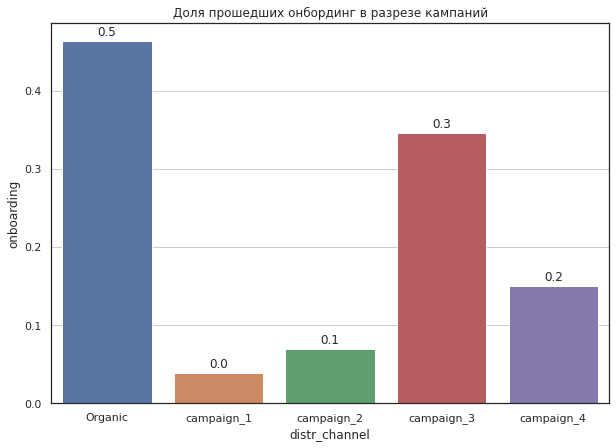

In [286]:
bar ('distr_channel', 'onboarding', 'mean', 'Доля прошедших онбординг в разрезе кампаний')

Видим, что факт прохождения онбординга действительно сильно влияет на все основные показатели. Пользователи прошедшие онбординг в среднем более активные, чаще кликают, чаще подписываются, чаще лайкают. 

Если смотреть на CTR, то разница почти 25%.

9.5% CTR у непрошедших онбординг против 12.4% CTR у прошедших.

#### Влияние места первого взаимодействия пользователя с Яндекс Дзеном на показатели

- Где 1 = Пользователь познакомился с Дзеном через Zen_app
- А 2 = Пользователь познакомился с Дзеном через другие приложения.

In [204]:
test.query('CTR != inf').groupby('first_app').mean().round(1)

,device_id,block,click,dislike,like,notification_click,preview_click,preview_show,short,show,subscription,rank,onboarding,CTR
first_app,,,,,,,,,,,,,,
0,9232469373719420928,0.0,12.2,0.2,0.4,0.3,1.8,27.2,12.5,71.5,0.1,134.9,0.1,10.5
1,9228998961270708224,0.0,11.6,0.2,0.5,0.8,1.2,10.4,2.3,75.0,0.4,38.0,0.2,9.7


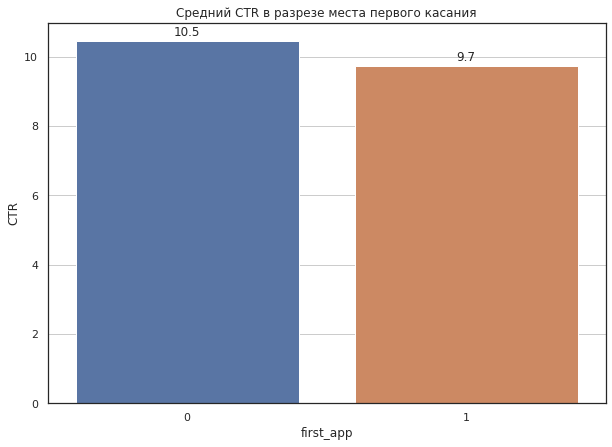

In [282]:
bar ('first_app', 'CTR', 'mean', 'Средний CTR в разрезе места первого касания')

Отличия в CTR есть, но нельзя назвать их существенными. Наиболее ярко проявляются различия в контексте взаимодействия пользователей с short контентом.

#### Влияние каналов трафика на показатели

In [192]:
test.query('CTR != inf').groupby('distr_channel').mean()

,device_id,block,click,dislike,like,notification_click,preview_click,preview_show,short,show,subscription,rank,first_app,onboarding,CTR
distr_channel,,,,,,,,,,,,,,,
Organic,9179768507849424896,0.133370,29.056810,0.508628,1.180549,1.115083,2.149994,25.665874,8.158393,172.333639,0.791562,107.221652,0.672810,0.463340,13.254370
campaign_1,9275407559812780032,0.013143,6.591491,0.072715,0.124840,0.709674,1.174981,11.553533,4.640864,47.837672,0.064031,60.898161,0.715029,0.039024,6.094343
campaign_2,9237023852157169664,0.004608,5.901627,0.052804,0.127863,0.093505,1.091201,17.763443,8.488058,36.808536,0.062925,83.443779,0.424058,0.069330,9.683203
campaign_3,9218270624252087296,0.044674,15.905951,0.290240,0.725394,1.001614,2.117469,20.878852,6.783884,94.954120,0.453323,94.792283,0.492500,0.345684,12.688066
campaign_4,9226378783526352896,0.021452,6.976250,0.104624,0.212038,0.269437,1.026631,16.891790,6.879899,44.925347,0.134198,71.433269,0.405902,0.150225,9.221676


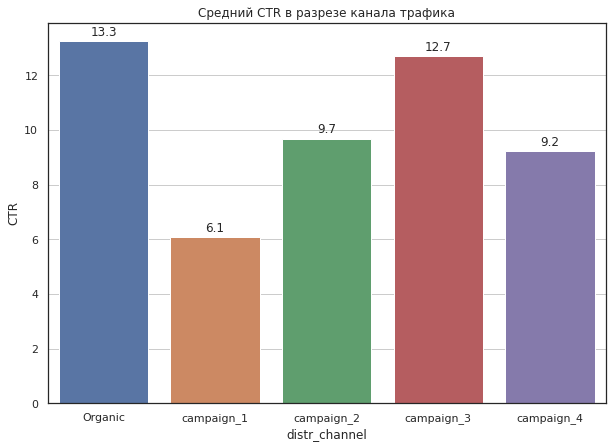

In [283]:
bar ('distr_channel', 'CTR', 'mean', 'Средний CTR в разрезе канала трафика')

Видим, что явными лидерами по CTR являются Organic и Campaign_3 трафик.
13.2% и 12.6% соотвественно. 

Сильно отстают Campaign_2 и Campaign_4 - у них CTR = 9%.

И явным аутсайдером является Campaign_1 с 6% CTR.

Смотрит на корреляцию признаков

In [193]:
corr = test.query('CTR != inf').groupby(['first_app','distr_channel']).mean().corr()

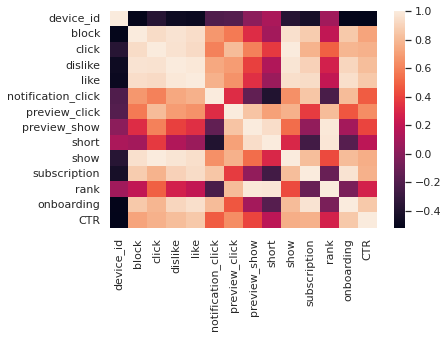

In [194]:
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

#### Влияние канала трафика на ключевые показатели только для данных по Zen App

In [195]:
test_agg = test.query('CTR != inf and app == "Zen App"').groupby('distr_channel').mean().round(1).\
merge(test.query('CTR != inf and app == "Zen App"').groupby('distr_channel')['device_id'].agg(count='count'), how="left", on='distr_channel')

In [196]:
test_agg

,device_id,block,click,dislike,like,notification_click,preview_click,preview_show,short,show,subscription,rank,first_app,onboarding,CTR,count
distr_channel,,,,,,,,,,,,,,,,
Organic,9181219940721445888,0.1,30.2,0.6,1.4,1.6,1.7,17.0,0.0,186.2,1.1,63.6,0.8,0.5,13.9,24449
campaign_1,9263807108632354816,0.0,4.5,0.1,0.1,0.9,1.0,0.9,0.0,39.5,0.1,17.1,0.8,0.0,5.7,35273
campaign_2,9268540657325895680,0.0,3.7,0.1,0.1,0.3,0.3,0.4,0.0,29.1,0.2,15.3,0.6,0.1,11.0,24067
campaign_3,9221597120609314816,0.1,17.8,0.4,1.0,1.9,2.0,8.7,0.0,112.9,0.8,50.3,0.7,0.4,13.9,26196
campaign_4,9206497260566535168,0.0,7.8,0.2,0.4,0.7,0.8,5.9,0.0,55.0,0.3,25.6,0.6,0.2,11.9,13392


Если же рассматривать CTR по каналам только для данных по Zen App, то ситуация в целом остается прежней. У Organic и Campaign_3 выросли CTR и они также остаются лидерами. У Campaign_2 и Campaign_4 рост CTR еще более заметный, однако отставание от лидеров все еще существенно. У Campaign 1 CTR снизился.

### Считаем retention rate по когортам в разрезе канала трафика

In [197]:
users = active[['device_id','activation_date', 'distr_channel']]
users['activation_week'] = users['activation_date'] - users['activation_date'].dt.weekday * np.timedelta64(1, 'D')
#users['activation_week'] = users['activation_date'].dt.week
min_date = zen['eventdate'].min()
max_date = zen['eventdate'].max()
day = pd.DataFrame(pd.date_range(min_date,max_date,freq='d'))
day.columns = ['day']
users['key'] = 1
day['key'] = 1
template = users.merge(day,on='key')[['device_id','activation_date','activation_week', 'distr_channel', 'day']]
template = template[template['day'] >= template['activation_week']]
active_day = metrika.groupby(['device_id','eventdate'])['events_count'].sum().reset_index()
active_day['week'] = active_day['eventdate'] - active_day['eventdate'].dt.weekday * np.timedelta64(1, 'D')
active_week = active_day.groupby(['device_id','week'])['events_count'].sum().reset_index()
active_week.columns = ['device_id','day','counts']
template['week'] = template['day'] - template['day'].dt.weekday * np.timedelta64(1, 'D')
report = template.merge(active_day,on=['device_id','week'],how='left')
report['active'] = (report['events_count'] > 0)*1

In [198]:
retention = report.pivot_table(index=['activation_week', 'distr_channel'],columns='week',values='active',aggfunc='mean')

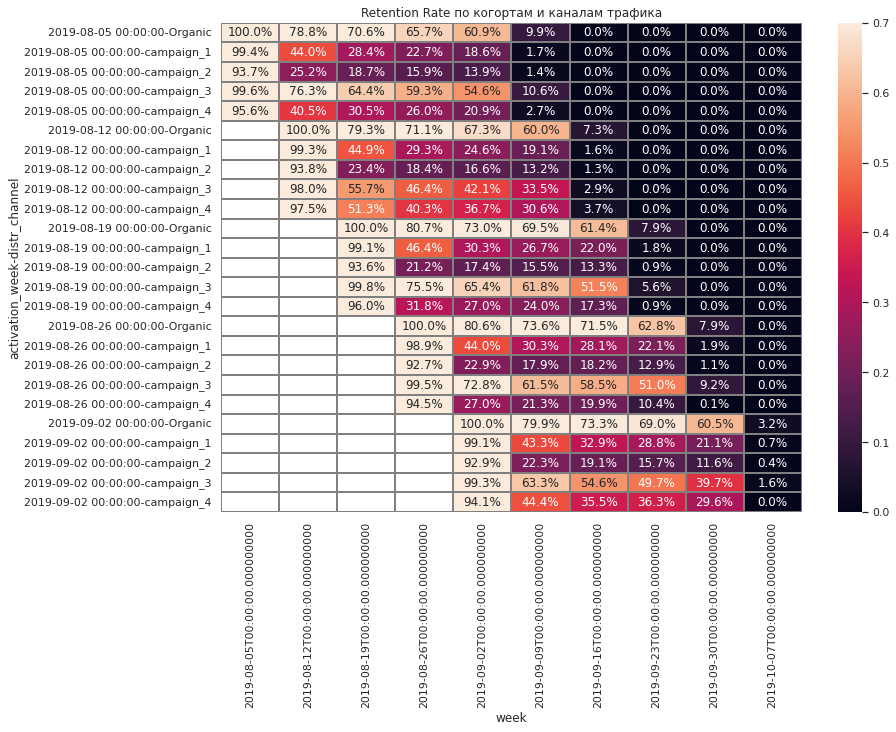

In [199]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Retention Rate по когортам и каналам трафика')
sns.heatmap(retention, annot=True, fmt='.1%', linewidths=1, linecolor='gray',
           vmax=0.7);

Также видим, что у органического трафика и трафика от Кампании 3 существенно более живучие пользователи. 

Так, в среднем, на 4-ую неделю жизни мы видим Retention по Organic и campaign_3 более 50%. Тогда как у остальных каналов трафика Retention на 4-ую неделю едва переваливает за 20-25%.

Также можно обратить внимание, что у второго канала трафика в первую неделю процент активных пользователей держится на уровне 92-93%. В то время как у остальных каналов показатели стремсятся к 100%. Возможно со второго канала частично приходит скам-трафик.

### Первое место взаимодействия с Дзеном и каналы трафика


In [200]:
test.query('CTR != inf').groupby('distr_channel')[['first_app','onboarding', 'CTR']].mean().reset_index()

,distr_channel,first_app,onboarding,CTR
0,Organic,0.672810,0.463340,13.254370
1,campaign_1,0.715029,0.039024,6.094343
2,campaign_2,0.424058,0.069330,9.683203
3,campaign_3,0.492500,0.345684,12.688066
4,campaign_4,0.405902,0.150225,9.221676


Видим, что в разрезе каналов: нет связи между местом первого взаимодействия и фактом прохождения онбординга. Следовательно фичу first_app можно смело отбрасывать в контексте анализа каналов трафика.

## Выводы

CTR и Retention Rate отлично себя показали в контексте анализа каналов трафика. 

Конверсия в онбординг же заметно влияет на показатели CTR и длительность жизни пользователя, поэтому эту характеристику стоит учитывать.

Место первого взаимодействия пользователя с Дзеном существенной роли не играет.


Для более глубокого анализа каналов трафика было бы классно получить следующие данные:
- Продолжительность сессии
- Факт дочитывания статьи до конца
- Продолжительность чтения статьи